In [7]:
!pip install numpy pandas matplotlib seaborn ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
dataset = pd.read_csv("Crimes_-_2001_to_Present_20250314.csv")

In [3]:
# Preprocessing
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Step 4: Standardizing text columns
dataset['Primary Type'] = dataset['Primary Type'].str.upper()
dataset['Location Description'] = dataset['Location Description'].str.upper()

# Step 5: Remove duplicates
dataset = dataset.drop_duplicates()

In [4]:
# Filter data

# exclude those without latitude
dataset = dataset[~dataset["Latitude"].isna()]

# exclude those in "rare locations" (< 20 occurrences, will make location processing simpler)
rare_locations = dataset.groupby("Location Description").filter(lambda x: len(x) < 20)["Location Description"].tolist()
dataset = dataset[~dataset["Location Description"].isin(rare_locations)]

In [5]:
pd.set_option('display.max_columns', None)
dataset.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3,13203321,JG415333,2023-09-06 17:00:00,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,122,1.0,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"
4,13204489,JG416325,2023-09-06 11:00:00,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,123,1.0,4.0,32.0,06,1176857.0,1896680.0,2023,11/04/2023 03:40:18 PM,41.871835,-87.626151,"(41.871834768, -87.62615082)"
5,11695116,JC272771,2019-05-21 08:20:00,018XX S CALIFORNIA AVE,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE,False,False,1023,10.0,25.0,29.0,05,1157982.0,1890961.0,2019,01/19/2024 03:40:50 PM,41.856547,-87.695605,"(41.856547057, -87.695604526)"
6,12419690,JE295655,2021-07-07 10:30:00,132XX S GREENWOOD AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,RESIDENCE,False,False,533,5.0,10.0,54.0,17,1186051.0,1817781.0,2021,01/19/2024 03:40:50 PM,41.655116,-87.594883,"(41.65511579, -87.594883198)"
7,12729745,JF279458,2022-06-14 14:47:00,035XX N CENTRAL AVE,0340,ROBBERY,ATTEMPT STRONG ARM - NO WEAPON,BANK,True,False,1633,16.0,30.0,15.0,03,1138391.0,1923142.0,2022,01/19/2024 03:40:50 PM,41.945232,-87.766735,"(41.945232412, -87.766734668)"


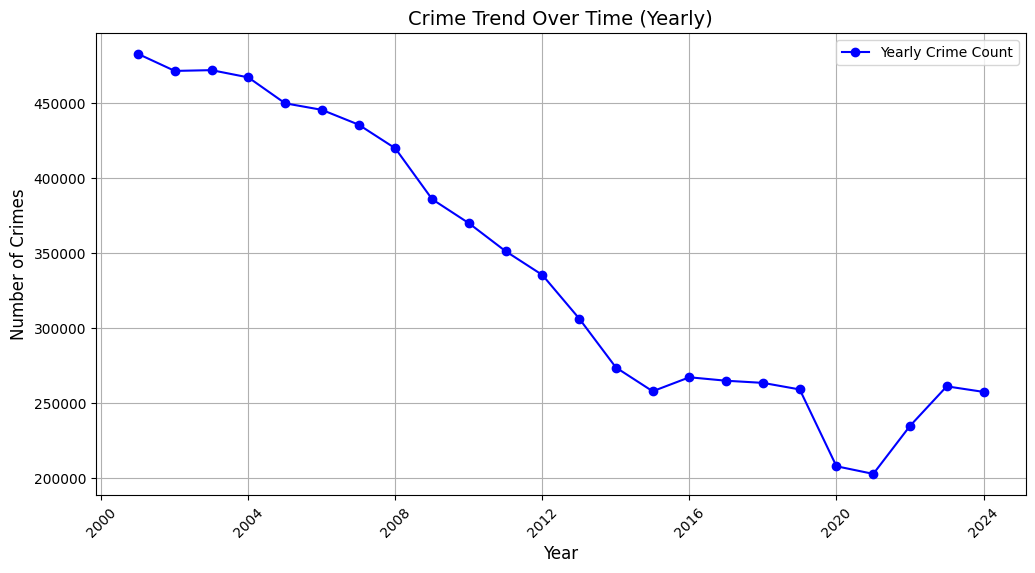

In [8]:
# Extract year
crimes_by_year = dataset["Date"].dt.to_period("Y")  # "Y" for yearly

# Aggregate crime counts per year and sort by time
crime_trend_yearly = crimes_by_year.value_counts().sort_index()

# Remove the last element
crime_trend_yearly = crime_trend_yearly.iloc[:-1]

# Convert to a datetime index for plotting
crime_trend_yearly.index = crime_trend_yearly.index.to_timestamp()

# Plot the yearly crime trend
plt.figure(figsize=(12, 6))
plt.plot(crime_trend_yearly, marker="o", linestyle="-", color="blue", label="Yearly Crime Count")

# Formatting the plot
plt.title("Crime Trend Over Time (Yearly)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Crimes", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

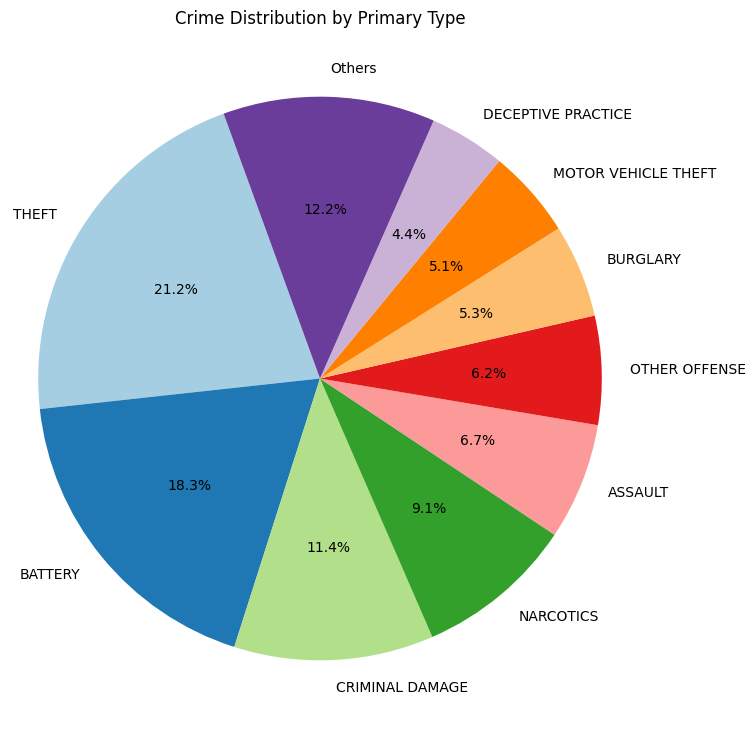

In [30]:
import matplotlib.pyplot as plt

# Group by Primary Type and count occurrences
crime_counts = dataset["Primary Type"].value_counts()

# Optional: Show only top 10 crime types for readability
top_crimes = crime_counts[:9]
top_crimes["Others"] = crime_counts.iloc[9:].sum()

# Plot the pie chart
plt.figure(figsize=(8, 9))
plt.pie(top_crimes, labels=top_crimes.index, autopct="%1.1f%%", startangle=110, colors=plt.cm.Paired.colors)

# Formatting
plt.title("Crime Distribution by Primary Type")
plt.axis("equal")  # Ensures pie is a circle
plt.show()

In [31]:
crime_counts

Primary Type
THEFT                                1732422
BATTERY                              1501112
CRIMINAL DAMAGE                       936479
NARCOTICS                             746505
ASSAULT                               548081
OTHER OFFENSE                         510407
BURGLARY                              437543
MOTOR VEHICLE THEFT                   416734
DECEPTIVE PRACTICE                    357017
ROBBERY                               309304
CRIMINAL TRESPASS                     222346
WEAPONS VIOLATION                     120738
PROSTITUTION                           69627
OFFENSE INVOLVING CHILDREN             55028
PUBLIC PEACE VIOLATION                 53834
SEX OFFENSE                            31280
CRIM SEXUAL ASSAULT                    25890
INTERFERENCE WITH PUBLIC OFFICER       19579
LIQUOR LAW VIOLATION                   15123
GAMBLING                               14555
ARSON                                  14091
HOMICIDE                               134

In [32]:
# so let us narrow down crime type

# We are interested in
CRIME_CATEGORIES = {
    "ASSAULT": [
        "BATTERY",
        "ASSAULT", 
        "ROBBERY", 
        "WEAPONS VIOLATION", 
        "HOMICIDE", 
        "INTIMIDATION"
    ],
    
    "SEX OFFENSE": [
        "SEX OFFENSE", 
        "CRIM SEXUAL ASSAULT", 
        "KIDNAPPING", 
        "CRIMINAL SEXUAL ASSAULT", 
        "STALKING"
    ],

    "THEFT": [
        "THEFT", 
        "CRIMINAL DAMAGE",  
        "MOTOR VEHICLE THEFT"
    ],

    "MINOR": [
        "NARCOTICS",
        "BURGLARY",
        "PROSTITUTION",
        "PUBLIC PEACE VIOLATION",
        "OBSCENITY",
        "PUBLIC INDECENCY",
        "ARSON"
    ],

    "IRRELEVANT": [
        "OTHER OFFENSE",
        "DECEPTIVE PRACTICE",
        "CRIMINAL TRESPASS",
        "OFFENSE INVOLVING CHILDREN",
        "CONCEALED CARRY LICENSE VIOLATION",
        "NON-CRIMINAL",
        "OTHER NARCOTIC VIOLATION",
        "HUMAN TRAFFICKING",
        "NON - CRIMINAL",
        "RITUALISM",
        "NON-CRIMINAL (SUBJECT SPECIFIED)",
        "DOMESTIC VIOLENCE"
    ]
}



In [ ]:
dataset["Category"] = None
for category, crime_list in CRIME_CATEGORIES.items():
    dataset.loc[dataset["Primary Type"].isin(crime_list), "Category"] = category

In [35]:
dataset.Category.value_counts(dropna=False)

Category
THEFT          3085635
ASSAULT        2497611
MINOR          1322682
IRRELEVANT     1146785
SEX OFFENSE      79374
None             49257
Name: count, dtype: int64

In [10]:
dataset["Location Description"].value_counts().reset_index().to_dict(orient="records")

[{'Location Description': 'STREET', 'count': 2146368},
 {'Location Description': 'RESIDENCE', 'count': 1341168},
 {'Location Description': 'APARTMENT', 'count': 960047},
 {'Location Description': 'SIDEWALK', 'count': 749474},
 {'Location Description': 'OTHER', 'count': 265312},
 {'Location Description': 'PARKING LOT/GARAGE(NON.RESID.)', 'count': 201305},
 {'Location Description': 'ALLEY', 'count': 182922},
 {'Location Description': 'SMALL RETAIL STORE', 'count': 162896},
 {'Location Description': 'SCHOOL, PUBLIC, BUILDING', 'count': 145531},
 {'Location Description': 'RESTAURANT', 'count': 137330},
 {'Location Description': 'RESIDENCE-GARAGE', 'count': 134746},
 {'Location Description': 'VEHICLE NON-COMMERCIAL', 'count': 128911},
 {'Location Description': 'RESIDENCE PORCH/HALLWAY', 'count': 123367},
 {'Location Description': 'DEPARTMENT STORE', 'count': 107595},
 {'Location Description': 'GROCERY FOOD STORE', 'count': 103057},
 {'Location Description': 'GAS STATION', 'count': 91795},
 

Let's rank these crimes

| **Primary Type**                          | **Walking** | **Biking** | **Public Transport** |
|-------------------------------------------|------------|------------|----------------------|
| **THEFT**                                 | 2          | 2          | 2                    |
| **BATTERY**                               | 2          | 2          | 2                    |
| **CRIMINAL DAMAGE**                       | 1          | 1          | 1                    |
| **NARCOTICS**                             | 1          | 1          | 1                    |
| **ASSAULT**                               | 2          | 2          | 2                    |
| **OTHER OFFENSE**                         | 1          | 1          | 1                    |
| **BURGLARY**                              | 1          | 1          | 0                    |
| **MOTOR VEHICLE THEFT**                   | 1          | 2          | 0                    |
| **DECEPTIVE PRACTICE**                    | 0          | 0          | 1                    |
| **ROBBERY**                               | 2          | 2          | 2                    |
| **CRIMINAL TRESPASS**                     | 1          | 1          | 1                    |
| **WEAPONS VIOLATION**                     | 2          | 2          | 2                    |
| **PROSTITUTION**                          | 0          | 0          | 0                    |
| **OFFENSE INVOLVING CHILDREN**            | 0          | 0          | 0                    |
| **PUBLIC PEACE VIOLATION**                | 1          | 1          | 2                    |
| **SEX OFFENSE**                           | 2          | 2          | 2                    |
| **CRIM SEXUAL ASSAULT**                   | 2          | 2          | 2                    |
| **INTERFERENCE WITH PUBLIC OFFICER**      | 1          | 1          | 1                    |
| **LIQUOR LAW VIOLATION**                  | 0          | 0          | 0                    |
| **GAMBLING**                              | 0          | 0          | 0                    |
| **ARSON**                                 | 2          | 2          | 2                    |
| **HOMICIDE**                              | 2          | 2          | 2                    |
| **CRIMINAL SEXUAL ASSAULT**               | 2          | 2          | 2                    |
| **KIDNAPPING**                            | 2          | 2          | 2                    |
| **STALKING**                              | 2          | 2          | 2                    |
| **INTIMIDATION**                          | 2          | 2          | 2                    |
| **CONCEALED CARRY LICENSE VIOLATION**     | 1          | 1          | 1                    |
| **OBSCENITY**                             | 0          | 0          | 0                    |
| **PUBLIC INDECENCY**                      | 1          | 1          | 1                    |
| **NON-CRIMINAL**                          | 0          | 0          | 0                    |
| **OTHER NARCOTIC VIOLATION**              | 1          | 1          | 1                    |
| **HUMAN TRAFFICKING**                     | 2          | 2          | 2                    |
| **NON - CRIMINAL**                        | 0          | 0          | 0                    |
| **RITUALISM**                             | 0          | 0          | 0                    |
| **NON-CRIMINAL (SUBJECT SPECIFIED)**      | 0          | 0          | 0                    |
| **DOMESTIC VIOLENCE**                     | 0          | 0          | 0                    |

### 🚶🚲🚆 Locations Relevant for People Moving Around the City
These locations are **more relevant** for pedestrians, cyclists, and public transport users:

| **Location**                            | **Count**   |
|-----------------------------------------|------------|
| **Street**                              | 2,146,368  |
| **Sidewalk**                            | 749,474    |
| **Alley**                               | 182,922    |
| **Parking Lot / Garage (Non-Residential)** | 201,305    |
| **Park Property**                       | 61,255     |
| **Vacant Lot / Land**                   | 24,477     |
| **Gas Station**                         | 91,795     |
| **CTA Bus / Train / Platform / Stop**   | 111,857    |
| **Public School (Building + Grounds)**  | 175,633    |
| **Private School (Building + Grounds)** | 18,326     |
| **College / University Grounds**        | 5,735      |
| **Public Transport-Related Areas** (Train depots, CTA garages, etc.) | ~30,000  |

In [11]:
# Public transport-related locations
PUBLIC_TRANSPORTS = [
    'CTA BUS STOP',
    'VEHICLE NON-COMMERCIAL',
    'TAXICAB',
    'CTA BUS',
    'VEHICLE-COMMERCIAL',
    'CTA PLATFORM',
    'CTA TRAIN',
    'VEHICLE - DELIVERY TRUCK',
    'CTA TRACKS - RIGHT OF WAY',
    'OTHER COMMERCIAL TRANSPORTATION',
    'CTA STATION',
    'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)',
    'VEHICLE - COMMERCIAL',
    'CTA GARAGE / OTHER PROPERTY',
    'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., LYFT, UBER, ETC.)',
    'CTA PARKING LOT / GARAGE / OTHER PROPERTY',
    'VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)',
    'VEHICLE - OTHER RIDE SERVICE',
]

AIRPORT = [
    'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA',
    'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA',
    'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA',
    'AIRPORT TRANSPORTATION SYSTEM (ATS)',
    'AIRPORT EXTERIOR - SECURE AREA',
    'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA',
    'AIRPORT EXTERIOR - NON-SECURE AREA',
    'AIRPORT BUILDING NON-TERMINAL - SECURE AREA',
    'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA',
    'AIRPORT/AIRCRAFT'
]



STORES = [
    'SMALL RETAIL STORE',
    'CAR WASH',
    'CLEANING STORE',
    'GROCERY FOOD STORE',
    'TAVERN / LIQUOR STORE',
    'MOVIE HOUSE / THEATER',
    'RESTAURANT',
    'CONVENIENCE STORE',
    'SPORTS ARENA / STADIUM',
    'RETAIL STORE',
    'DEPARTMENT STORE',
    'COMMERCIAL / BUSINESS OFFICE',
    'FACTORY/MANUFACTURING BUILDING',
    'BAR OR TAVERN',
    'BARBER SHOP/BEAUTY SALON'
]

# Street-related locations
STREET = [
    'SCHOOL, PRIVATE, GROUNDS',
    'VACANT LOT/LAND',
    'ALLEY',
    'COLLEGE / UNIVERSITY GROUNDS',
    'AIRPORT EXTERIOR - SECURE AREA',
    'HIGHWAY/EXPRESSWAY',
    'FOREST PRESERVE',
    'PARKING LOT',
    'PARKING LOT / GARAGE (NON RESIDENTIAL)',
    'SCHOOL, PUBLIC, BUILDING',
    'SCHOOL - PRIVATE GROUNDS',
    'PARKING LOT/GARAGE(NON.RESID.)',
    'NEWSSTAND',
    'LAKEFRONT/WATERFRONT/RIVERBANK',
    'BRIDGE',
    'HOSPITAL BUILDING/GROUNDS',
    'COLLEGE / UNIVERSITY - GROUNDS',
    'VACANT LOT',
    'HIGHWAY / EXPRESSWAY',
    'OTHER (SPECIFY)',
    'POLICE FACILITY/VEH PARKING LOT',
    'CHA PARKING LOT/GROUNDS',
    'PARK PROPERTY',
    'OTHER RAILROAD PROP / TRAIN DEPOT',
    'VEHICLE - DELIVERY TRUCK',
    'PARKING LOT / GARAGE(NON.RESID.)',
    'BANK',
    'SIDEWALK',
    'LAKEFRONT / WATERFRONT / RIVERBANK',
    'POLICE FACILITY / VEHICLE PARKING LOT',
    'STREET',
    'VACANT LOT / LAND',
    'CEMETARY',
    'SCHOOL - PUBLIC BUILDING',
    'GAS STATION',
    'ATM (AUTOMATIC TELLER MACHINE)',
    'SCHOOL, PUBLIC, GROUNDS',
    'DELIVERY TRUCK'
]

# Private locations
PRIVATE = [  
    'COLLEGE / UNIVERSITY - RESIDENCE HALL',
    'HALLWAY',
    'CASINO/GAMBLING ESTABLISHMENT',
    'CHA HALLWAY',
    'YARD',
    'AUTO / BOAT / RV DEALERSHIP',
    'CHURCH / SYNAGOGUE / PLACE OF WORSHIP',
    'SAVINGS AND LOAN',
    'RESIDENCE - PORCH / HALLWAY',
    'FEDERAL BUILDING',
    'MEDICAL / DENTAL OFFICE',
    'BOAT/WATERCRAFT',
    'FIRE STATION',
    'RESIDENCE-GARAGE',
    'JAIL / LOCK-UP FACILITY',
    'SPORTS ARENA/STADIUM',
    'COIN OPERATED MACHINE',
    'DRIVEWAY',
    'BARBER SHOP / BEAUTY SALON',
    'HOUSE',
    'MOVIE HOUSE/THEATER',
    'HOTEL/MOTEL',
    'SCHOOL - PRIVATE BUILDING',
    'CHURCH/SYNAGOGUE/PLACE OF WORSHIP',
    'SCHOOL - PUBLIC GROUNDS',
    'HOTEL / MOTEL',
    'BOWLING ALLEY',
    'RESIDENCE - GARAGE',
    'CREDIT UNION',
    'COLLEGE/UNIVERSITY RESIDENCE HALL',
    'GOVERNMENT BUILDING/PROPERTY',
    'DAY CARE CENTER',
    'HOSPITAL BUILDING / GROUNDS',
    'HOTEL',
    'AIRCRAFT',
    'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA',
    'MEDICAL/DENTAL OFFICE',
    'POOL ROOM',
    'APPLIANCE STORE',
    'VESTIBULE',
    'NURSING HOME/RETIREMENT HOME',
    'BASEMENT',
    'SPORTS ARENA / STADIUM',
    'PORCH',
    'AUTO',
    'ABANDONED BUILDING',
    'NURSING / RETIREMENT HOME',
    'TAVERN',
    'CHA PARKING LOT / GROUNDS',
    'VACANT LOT / LAND',
    'ANIMAL HOSPITAL',
    'GARAGE',
    'OTHER RAILROAD PROPERTY / TRAIN DEPOT',
    'CONSTRUCTION SITE',
    'STAIRWELL',
    'RESIDENCE - YARD (FRONT / BACK)',
    'COLLEGE/UNIVERSITY GROUNDS',
    'SCHOOL, PRIVATE, BUILDING',
    'AIRPORT PARKING LOT',
    'RESIDENCE',
    'FACTORY / MANUFACTURING BUILDING',
    'PAWN SHOP',
    'RESIDENCE PORCH/HALLWAY',
    'DRIVEWAY - RESIDENTIAL',
    'GOVERNMENT BUILDING / PROPERTY',
    'AIRPORT VENDING ESTABLISHMENT',
    'BOAT / WATERCRAFT',
    'CHA GROUNDS',
    'GAS STATION DRIVE/PROP.',
    'COLLEGE / UNIVERSITY RESIDENCE HALL',
    'DRUG STORE',
    'CHA HALLWAY/STAIRWELL/ELEVATOR',
    'CHA PARKING LOT',
    'RESIDENTIAL YARD (FRONT/BACK)',
    'TAVERN/LIQUOR STORE',
    'CHA APARTMENT',
    'OTHER',
    'CURRENCY EXCHANGE',
    'SCHOOL - PRIVATE GROUNDS',
    'TAVERN / LIQUOR STORE',
    'OFFICE',
    'CASINO / GAMBLING ESTABLISHMENT',
    'WAREHOUSE',
    'BARBERSHOP',
    'GANGWAY',
    'CHA HALLWAY / STAIRWELL / ELEVATOR',
    'APARTMENT',
    'LIBRARY',
    'ATHLETIC CLUB',
    'CHA HALLWAY''AUTO / BOAT / RV DEALERSHIP',
]




In [12]:
dataset["Location Category"] = None
dataset.loc[dataset["Location Description"].isin(PUBLIC_TRANSPORTS), "Location Category"] = "Public Transports"
dataset.loc[dataset["Location Description"].isin(STREET), "Location Category"] = "Street"
dataset.loc[dataset["Location Description"].isin(AIRPORT), "Location Category"] = "Airport"
dataset.loc[dataset["Location Description"].isin(STORES), "Location Category"] = "Stores"
dataset.loc[dataset["Location Description"].isin(PRIVATE), "Location Category"] = "Non concerning"
dataset["Location Category"].value_counts()

Location Category
Street               3856340
Non concerning       3344548
Stores                665939
Public Transports     276294
Airport                29160
Name: count, dtype: int64

In [47]:
dataset.Category.value_counts(dropna=False)

Category
THEFT          2078913
ASSAULT        1416628
MINOR           827427
IRRELEVANT      441289
None             41387
SEX OFFENSE      31152
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

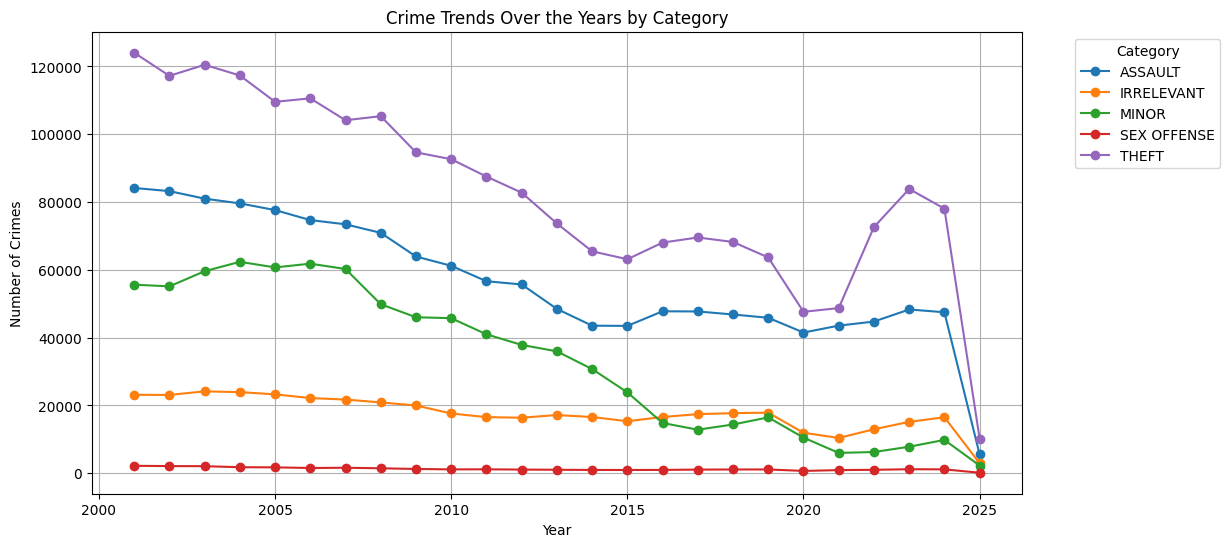

In [48]:
# Load the dataset
dataset["Year"] = dataset["Date"].dt.year

# Group by year and category, then count occurrences
crime_trends = dataset.groupby(["Year", "Category"]).size().unstack()
plt.figure(figsize=(12, 6))
crime_trends.plot(marker='o', figsize=(12, 6))

plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Crime Trends Over the Years by Category")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

plt.show()

In [42]:
# Now condition on location
dataset = dataset[dataset["Category"] != 'Irrelevant']
dataset = dataset[dataset["Location Category"] != 'Non concerning']

<Figure size 1200x600 with 0 Axes>

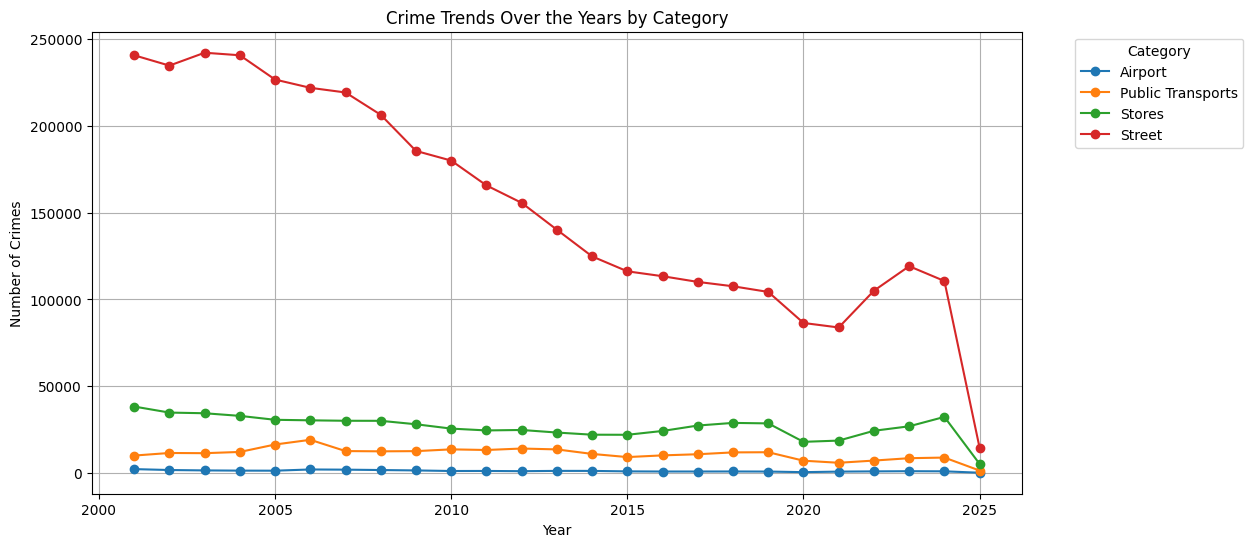

In [43]:
# Load the dataset
dataset["Year"] = dataset["Date"].dt.year

# Group by year and category, then count occurrences
crime_trends = dataset.groupby(["Year", "Location Category"]).size().unstack()
plt.figure(figsize=(12, 6))
crime_trends.plot(marker='o', figsize=(12, 6))

plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Crime Trends Over the Years by Category")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

plt.show()


In [ ]:
# So let's look at the trend over time for these categories
# Example of map and use case: 


In [51]:
dataset["Location Category"]

3          Street
4          Street
7          Street
8          Street
10         Street
            ...  
8273338      None
8273342    Street
8273344    Street
8273346    Street
8273347    Street
Name: Location Category, Length: 4836796, dtype: object

In [49]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets
import matplotlib.dates as mdates

# Extract hour from date
dataset['hour'] = dataset['Date'].dt.hour

# Create the interactive function
def plot_crime_time_distribution(type, location):
    # Filter data by selected crime type
    filtered_df = dataset[(dataset['Category'] == type) & (dataset["Location Category"] == location)] 
    
    # Plotting the distribution of crime time
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_df['hour'], bins=24, kde=False, color='blue', edgecolor='black')
    
    # Customizing the plot
    plt.title(f'Crime Time Distribution for SEX OFFENSE')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Count of Crimes')
    plt.xticks(range(24), [f'{i}:00' for i in range(24)], rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Create a dropdown to select crime type
#crime_type_dropdown = widgets.Dropdown(
#    options=dataset['Primary Type'].unique(),
#    description='Crime Type:',
#    disabled=False
#)

# Use the interact function to make the plot dynamic
#interact(plot_crime_time_distribution, crime_type=crime_type_dropdown)

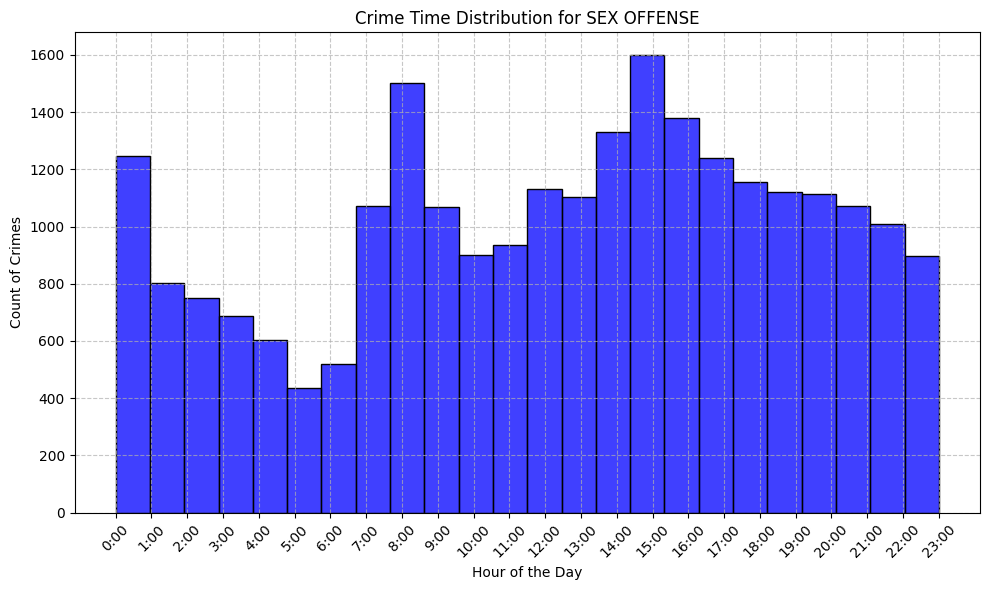

In [53]:
from typing import Tuple


plot_crime_time_distribution("SEX OFFENSE", "Street")

def get_slice(category: str, location: str, hour_range: Tuple[int, int]):
    return dataset[(dataset['Category'] == category) 
                   & (dataset["Location Category"] == location)
                   & (hour_range[0] <= dataset["hour"])
                   & (hour_range[1] > dataset["hour"])]

In [ ]:
# Start to narrow down
 

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Location Category,Category,hour
757,13202168,JG414185,2023-09-06 13:15:00,058XX N RIDGE AVE,1563,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,ALLEY,False,False,2013,20.0,48.0,77.0,17,1165024.0,1939181.0,2023,09/14/2023 03:43:09 PM,41.988719,-87.668384,"(41.988719229, -87.668384208)",Street,SEX OFFENSE,13
778,13208573,JG421611,2023-08-25 15:00:00,021XX N CALIFORNIA AVE,0584,STALKING,VIOLATION OF STALKING NO CONTACT ORDER,POLICE FACILITY / VEHICLE PARKING LOT,False,True,1414,14.0,1.0,22.0,26,1157345.0,1914452.0,2023,09/14/2023 03:41:59 PM,41.921021,-87.697304,"(41.921021491, -87.69730355)",Street,SEX OFFENSE,15
3116,13210653,JG424178,2023-09-07 13:24:00,039XX N MELVINA AVE,0584,STALKING,VIOLATION OF STALKING NO CONTACT ORDER,SIDEWALK,False,False,1633,16.0,38.0,17.0,26,1134323.0,1925692.0,2023,09/16/2023 03:41:56 PM,41.952303,-87.781627,"(41.952302697, -87.781627)",Street,SEX OFFENSE,13
5904,13207424,JG420125,2023-09-11 14:38:00,074XX N HOYNE AVE,1570,SEX OFFENSE,PUBLIC INDECENCY,STREET,False,False,2424,24.0,49.0,1.0,17,1160973.0,1949510.0,2023,09/19/2023 03:42:46 PM,42.017148,-87.682996,"(42.017147654, -87.682995673)",Street,SEX OFFENSE,14
7294,13694330,JH545316,2024-12-16 14:00:00,029XX W LAKE ST,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,ALLEY,False,False,1222,12.0,27.0,27.0,02,1156731.0,1900998.0,2024,12/24/2024 03:41:09 PM,41.884115,-87.699925,"(41.884115019, -87.699924527)",Street,SEX OFFENSE,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8262721,13656388,JH499217,2024-11-07 15:00:00,030XX W 39TH PL,1792,KIDNAPPING,CHILD ABDUCTION / STRANGER,STREET,False,False,921,9.0,12.0,58.0,26,1156780.0,1878278.0,2024,02/25/2025 03:41:40 PM,41.821768,-87.700360,"(41.821767828, -87.700359595)",Street,SEX OFFENSE,15
8265387,13755175,JJ157103,2025-02-21 15:25:00,026XX W LUNT AVE,0580,STALKING,SIMPLE,SIDEWALK,True,False,2411,24.0,50.0,2.0,08A,1157433.0,1946345.0,2025,03/01/2025 03:41:07 PM,42.008536,-87.696109,"(42.008535858, -87.696108723)",Street,SEX OFFENSE,15
8267090,13757840,JJ160310,2025-02-24 13:08:00,065XX S CHAMPLAIN AVE,1570,SEX OFFENSE,PUBLIC INDECENCY,STREET,False,False,321,3.0,20.0,42.0,17,1181693.0,1861749.0,2025,03/04/2025 03:41:22 PM,41.775871,-87.609477,"(41.77587085, -87.609476619)",Street,SEX OFFENSE,13
8270095,13761784,JJ165109,2025-02-28 15:38:00,013XX N WASHTENAW AVE,1570,SEX OFFENSE,PUBLIC INDECENCY,STREET,False,False,1423,14.0,26.0,24.0,17,1158151.0,1909120.0,2025,03/08/2025 03:41:07 PM,41.906374,-87.694488,"(41.906373621, -87.694488042)",Street,SEX OFFENSE,15


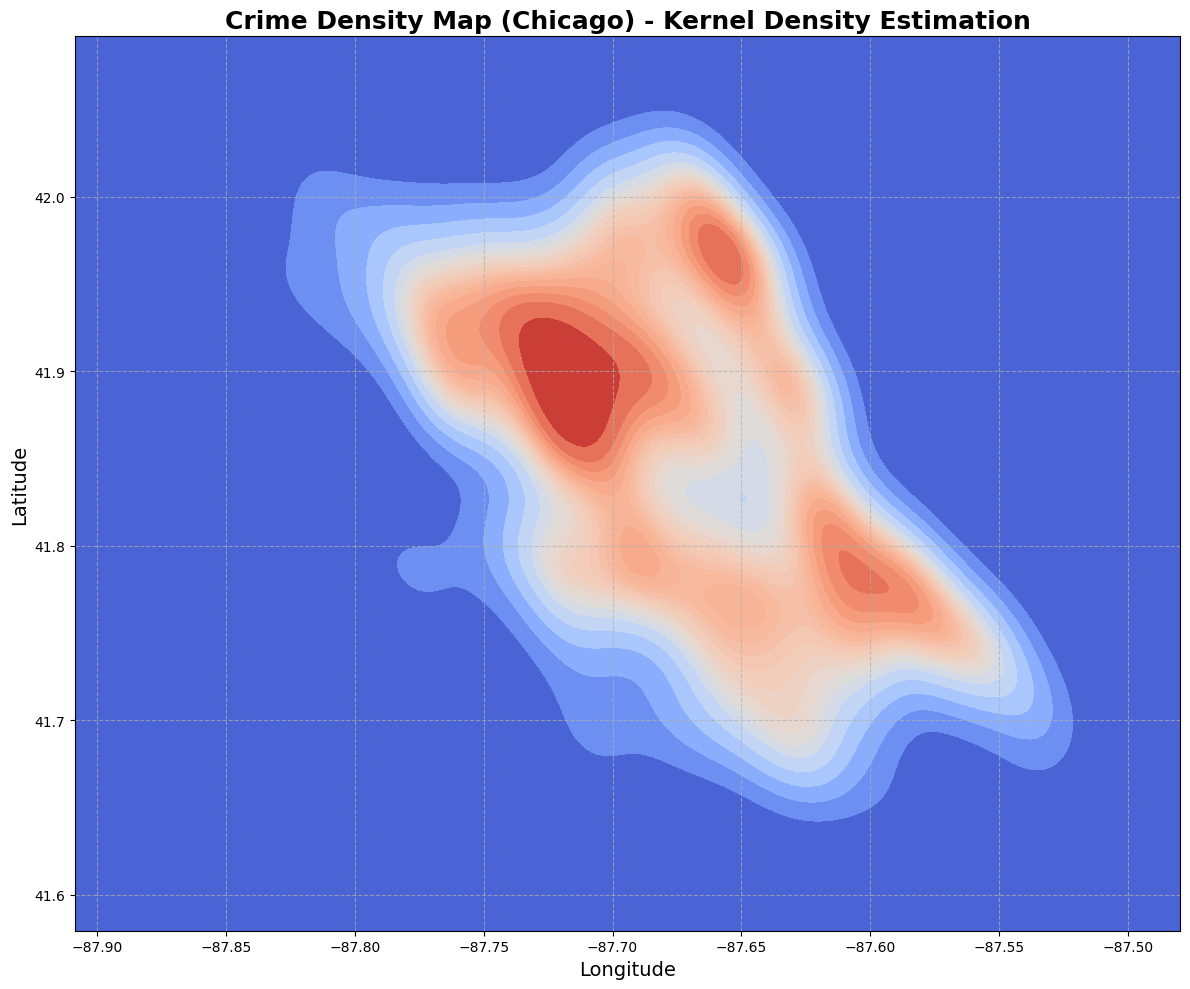

In [57]:
# Set the plot size
plt.figure(figsize=(12, 10))

# Create the plot with KDE for latitude and longitude
crimes_selected = get_slice("SEX OFFENSE", "Street", (13, 16))
sns.kdeplot(x=crimes_selected['Longitude'], 
            y=crimes_selected['Latitude'], 
            fill=True, 
            thresh=0, 
            levels=20, 
            cmap='coolwarm')

# Set plot title and axis labels with larger font sizes
plt.title("Crime Density Map (Chicago) - Kernel Density Estimation", fontsize=18, weight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Add a color bar to show the density levels

# Improve readability with a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing and alignment
plt.tight_layout()

# Show the plot
plt.show()

In [59]:
!pip install folium

import pandas as pd
import folium
from folium.plugins import HeatMap


In [89]:
dangerous_locations = [
    'STREET',
    'ALLEY',
    'SIDEWALK',
    'PARK PROPERTY',
    'VACANT LOT / LAND',
    'BRIDGE',
    'LAKEFRONT / WATERFRONT / RIVERBANK',
    'GAS STATION',
    'PARKING LOT / GARAGE (NON RESIDENTIAL)',
    'CTA PLATFORM',
    'CTA STATION',
    'CTA BUS STOP',
    'CTA TRAIN',
    'AIRPORT EXTERIOR - NON-SECURE AREA',
    'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA',
    'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA',
    'VEHICLE - COMMERCIAL',
    'AUTO / BOAT / RV DEALERSHIP',
    'FACTORY / MANUFACTURING BUILDING',
    'OTHER RAILROAD PROPERTY / TRAIN DEPOT',
    'OTHER COMMERCIAL TRANSPORTATION'
]


In [81]:
import folium
from folium.plugins import HeatMap

# Create a folium map centered around Chicago
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# Function to get the crime data slice (assuming you have this function)
crimes_selected = get_slice("SEX OFFENSE", "Street", (21, 24))
crimes_selected = pd.concat([crimes_selected, get_slice("ASSAULT", "Street", (21, 24))])


# Prepare the data for HeatMap
heat_data = [[row['Latitude'], row['Longitude']] for _, row in crimes_selected.iterrows() if row["Latitude"] is not None]

# Add the HeatMap layer
heatmap = HeatMap(
    heat_data,
    min_opacity=0.2,  
    radius=60,        
    blur=15, 
    max_zoom=40,      
).add_to(chicago_map)

# Add pinpoint markers for Loyola University Chicago and The Shops at North Bridge
locations = [
    {"name": "Loyola University Chicago", "lat": 42.0010, "lon": -87.6606, "color": "blue"},
    {"name": "The Shops at North Bridge", "lat": 41.8917, "lon": -87.6240, "color": "red"}
]

# Add markers to the map
for loc in locations:
    folium.Marker(
        location=[loc["lat"], loc["lon"]],
        popup=loc["name"],  # Clickable label
        icon=folium.Icon(color=loc["color"], icon="info-sign")  # Customize icon
    ).add_to(chicago_map)

# Save the map as an HTML file
chicago_map.save("crime_selected_density_map.html")


In [ ]:
cirm